### Classification: Natural Gas Data Set
We'll classify our data using the dataset of natural gas prices. Classification tries to predict, which of a small set of classes, an observation belongs to. Mathematically, the aim is to find  yy, a label based on knowing a feature vector  xx . In our case we will consider predicting gas price by identifying the weather. To have a machine do this well, we would typically feed the machine a bunch of gas prices which have been labelled "WSTAT = 0" or "WSTAT =1" (the training set), and have it learn the gas price in the dataset from the labels and the features used to determine gas prices. Then, given a new weather status, the trained algorithm returns us the gas price that is expected for such a weather Status. "0" is the used to denote when the weather is either SPRING or FALL while "1" denotes that period when the weather is WINTER or SUMMER.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

In [3]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [4]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

 We load the data into a dataframe and plot it.

In [6]:
#load the data for analysis
dflog=pd.read_excel("data/DataSet_GasPrice_ Outlier_Removed.xlsx")
dflog.head()

,Days,Date,AveCoalPrice,OilPrice,GrossGasProd,TotGasCons,GasPrice,Weather,WSTAT,GasPriceStatus
0,245,2008-12-31,57.22,41.12,2227.028,2399.702,5.82,WINTER,1,HIGH
1,276,2009-01-31,54.37,41.71,2251.938,2729.715,5.24,WINTER,1,HIGH
2,304,2009-02-28,52.30,39.09,2074.167,2332.539,4.52,WINTER,1,HIGH
3,335,2009-03-31,44.34,47.94,2262.488,2170.709,3.96,WINTER,1,HIGH
4,365,2009-04-30,41.92,49.65,2147.856,1741.293,3.50,SPRING,0,HIGH


In [7]:
#Change the columns name to create attributes and features
dflog.columns = ['DAYS', 'DATE', 'COALP', 'OILP', 'GPROD', 'GCONS', 'GASP', 'WEATH', 'WSTAT', 'GPSTAT']
dflog.head()

,DAYS,DATE,COALP,OILP,GPROD,GCONS,GASP,WEATH,WSTAT,GPSTAT
0,245,2008-12-31,57.22,41.12,2227.028,2399.702,5.82,WINTER,1,HIGH
1,276,2009-01-31,54.37,41.71,2251.938,2729.715,5.24,WINTER,1,HIGH
2,304,2009-02-28,52.30,39.09,2074.167,2332.539,4.52,WINTER,1,HIGH
3,335,2009-03-31,44.34,47.94,2262.488,2170.709,3.96,WINTER,1,HIGH
4,365,2009-04-30,41.92,49.65,2147.856,1741.293,3.50,SPRING,0,HIGH


In [8]:
dflog['DATE'] =  pd.to_datetime(dflog['DATE'], format='%m/%d/%Y')

We now generate a time series plot for gas price. 

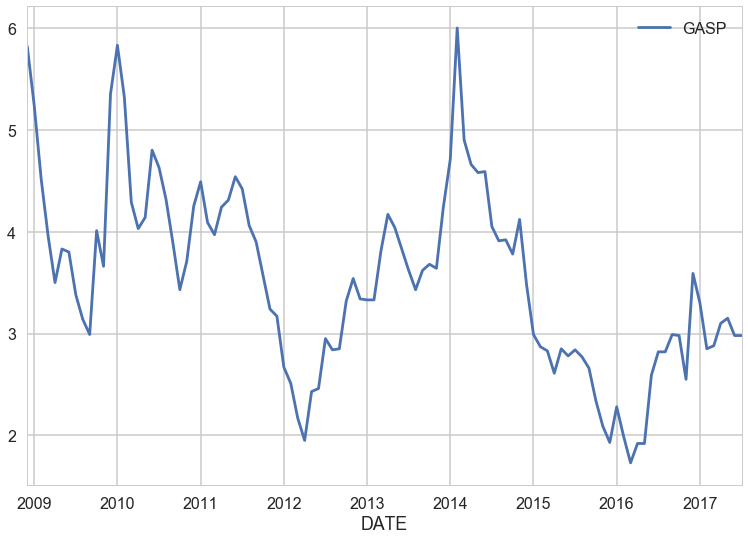

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
dflog[['DATE','GASP']].set_index('DATE').plot()

We also check whether gas price varies according to the weather.

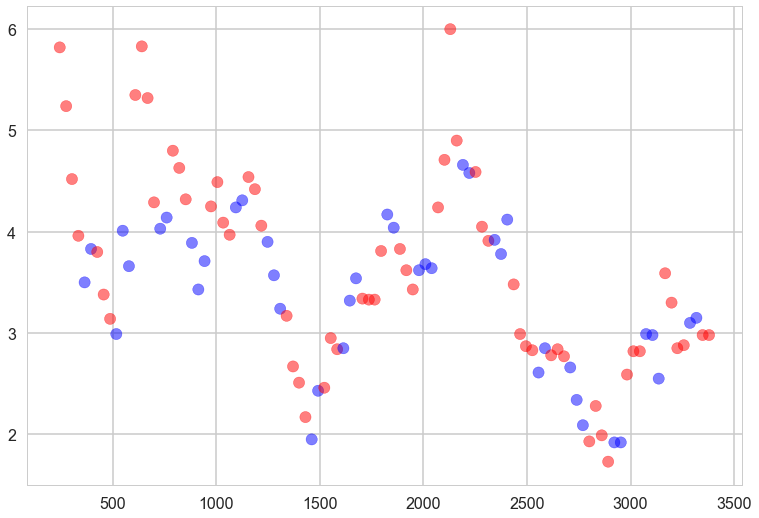

In [10]:
plt.scatter(dflog.DAYS, dflog.GASP, c=[cm_bright.colors[i] for i in dflog.WSTAT == 0], alpha=0.5);

Observe that the periods of gas price peaks correspond to winter and summer months (in red). Let us further investigate the validity of the classification by plotting gas price as a function of other variables

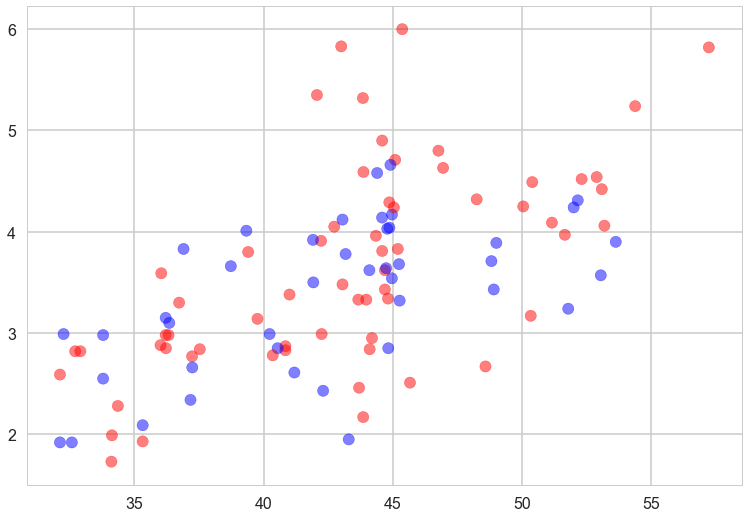

In [11]:
# Plot of gas price against coal price
plt.scatter(dflog.COALP, dflog.GASP, c=[cm_bright.colors[i] for i in dflog.WSTAT == 0], alpha=0.5);

We observe that gas price increases with coal price. However the period of equivalent peak prices of coal and gas price seems to be consistent with the summer and winter months.

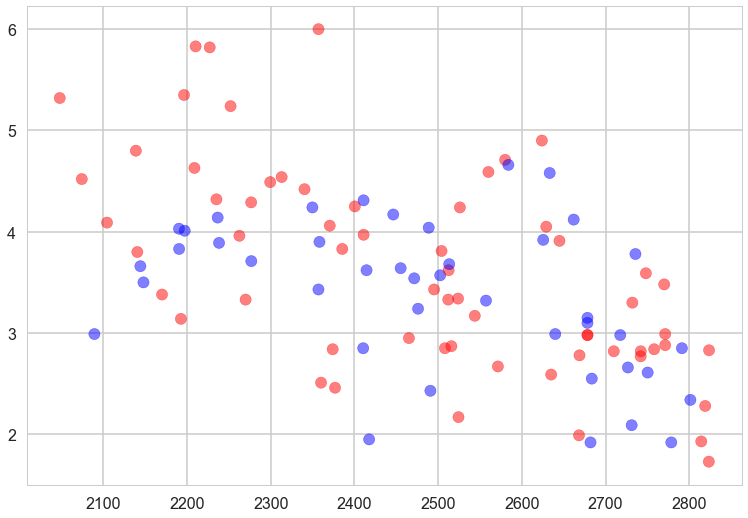

In [12]:
# Plot of gas price against gas production
plt.scatter(dflog.GPROD, dflog.GASP, c=[cm_bright.colors[i] for i in dflog.WSTAT == 0], alpha=0.5);

Gas price seems to decrease with increased production of gas. It could also be observed that the period of low production of Gas coupled with severe weather saw peak rise in gas prices. 

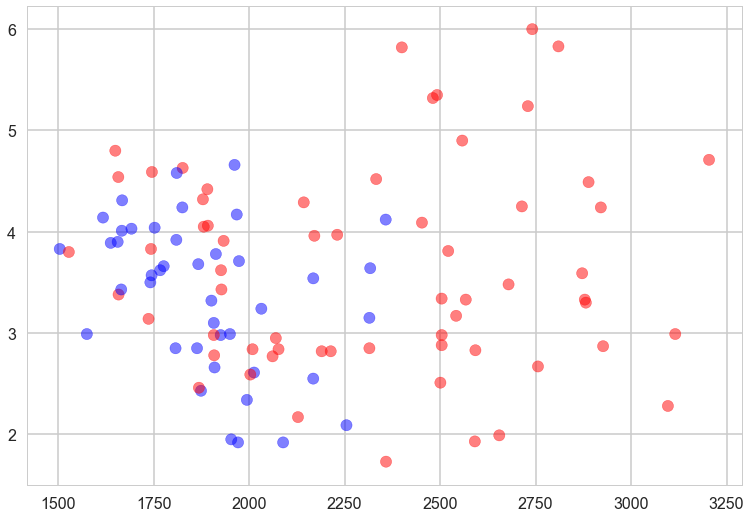

In [13]:
plt.scatter(dflog.GCONS, dflog.GASP, c=[cm_bright.colors[i] for i in dflog.WSTAT == 0], alpha=0.5);

There is a clear distiction between period of low gas consumption (<2500 MMscf) and period of high gas consumption (>2500 MMscf). Increase in gas consumption is equivalent to increase in demands for gas. The period of low gas consumption falls within the period of spring and fall weather while during the winter and summer, gas demand is on the increase.

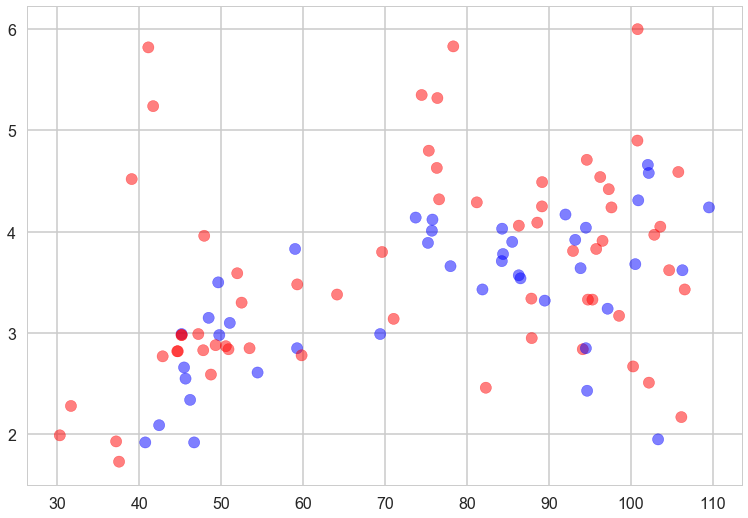

In [14]:
plt.scatter(dflog.OILP, dflog.GASP, c=[cm_bright.colors[i] for i in dflog.WSTAT == 0], alpha=0.5);

Gas Price relatively increases with Oil Price. It is observed that periods of peak in gas prices are consistent with the period of winter and summer 

#### Training and Test Datasets
When fitting models, we would like to ensure two things:
(1) We have found the best model (in terms of model parameters).
(2) The model is highly likely to generalize i.e. perform well on unseen data.

First, we try a basic Logistic Regression:
(1) Split the data into a training and test (hold-out) set
(2) Train on the training set, and test for accuracy on the testing set

Let us start with the relationship that has the most explicit classification: That is classification of Gas price and Gas Consumption with respect to weather Status. 

In [15]:
# Split data into training set and testing set
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['GASP','GCONS']].values, 
                                              (dflog.WSTAT == 0).values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.576923076923


In this case, the accuracy score is 0.58.

### Tuning the Model
The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of our model, we will use a mix of cross-validation and grid search. In Logistic Regression, the most important parameter to tune is the regularization parameter C. We will note that the regularization parameter is not always part of the logistic regression model.

The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

We will now implement some code to perform model tuning and selecting the regularization parameter  C.

We will use the following cv_score function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [16]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

C:\Users\Angus\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In order to find a good model using all the key independent variables, we will use a given list of possible values of C. For each C, we will create a logistic regression model with that value of C. We will find the average score for this model using the cv_score function only on the training set (Xlr, ylr) and we will then pick the C with the highest average score

The goal is to find the best model parameters based only on the training set, without showing the model test set at all.

In [17]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['COALP','OILP', 'GPROD', 'GCONS', 'GASP']].values, (dflog.WSTAT == 0).values)

In [18]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, Xlr, ylr)

        if score > max_score:
            max_score = score
            best_C =C
print (max_score, best_C)

0.705 0.1


Here we see that the maximum score is 0.70 while the best C is 1. We will now evaluate the accuracy score of our prediction.

In [19]:
clfl=LogisticRegression(C=best_C)
clfl.fit(Xlr, ylr)
ypred=clfl.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

0.73076923076923073

Using grid search CV, we have:

In [20]:
from sklearn.grid_search import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

C:\Users\Angus\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(LogisticRegression(C=0.0001, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 {'C': 0.0001},
 0.717948717948718,
 [mean: 0.71795, std: 0.09042, params: {'C': 0.0001},
  mean: 0.70513, std: 0.06948, params: {'C': 0.001},
  mean: 0.69231, std: 0.07652, params: {'C': 0.1},
  mean: 0.67949, std: 0.09017, params: {'C': 1},
  mean: 0.67949, std: 0.09017, params: {'C': 10},
  mean: 0.67949, std: 0.09017, params: {'C': 100}])

We observe that the best C is 0.0001 and the maximum score is 0.718. Now we generate the accuracy score of our prediction

In [21]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2=clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

0.73076923076923073

In these cases, we have used a squared error loss function along with Empirical Risk Minimization (ERM) to carry out regression. The idea there was to calculate this risk on the training set and minimize it. Then the hope was that on the population, or any testing set representative of it, the out-of-sample risk was similar in size to the in-sample training risk, and thus small. The question then is what might be an appropriate risk for classification? One immediately comes to mind: the fraction of misclassified samples. Since the accuray score for our model is 77%, it suggests that the risk that a portion of the sample is misclassified is 27%

In [22]:
dfnum = dflog[['COALP', 'OILP', 'GPROD', 'GCONS', 'GASP']]
dfnum.head()

,COALP,OILP,GPROD,GCONS,GASP
0,57.22,41.12,2227.028,2399.702,5.82
1,54.37,41.71,2251.938,2729.715,5.24
2,52.30,39.09,2074.167,2332.539,4.52
3,44.34,47.94,2262.488,2170.709,3.96
4,41.92,49.65,2147.856,1741.293,3.50


### Principal Components Analysis
#### The curse of dimensionality: Feature engineering
Let us recall that having too many features can lead to overfitting. We will engage in some a-priori feature selection that will reduce the dimensionality of the problem. The idea we'll use here is called Principal Components Analysis, or PCA. PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. There are as many principal components as the feature dimension: all we have done is a rotation.

How does this then achieve feature selection? We decide on a threshold of variation; once the variation in a particular direction falls below a certain number, we get rid of all the co-ordinate axes after that principal component. For example, if the variation falls below 10% after the third axes, and we decide that 10% is an acceptable cutoff, we remove all domensions from the fourth dimension onwards. In other words, we took our higher dimensional problem and projected it onto a 3 dimensional subspace.

Here we'll continue to focus on PCA. We'll reduce our dimensionality from 5 to 3. We choose 3 as a large apriori number: we dont know if the variation in the data will have gone below a reasonable threshold by then. 

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
dfnum 
X = pca.fit_transform(dfnum)

In [24]:
print (pca.explained_variance_ratio_.sum())

0.999925003031


The explained variance ratio pca.explained_variance_ratio_ tells us how much of the variation in the features is explained by these 3 features. When we sum it up over the features, we see that more than 99% is explained: good enough to go down to a 3 dimensional space from a 5 dimensional one! 

We can see the individual varainces as we increase the dimensionality:

In [25]:
pca.explained_variance_ratio_*100

array([ 80.94802344,  18.82730987,   0.21716699])

The first dimension accounts for 81% of the variation, the second 19%, and it goes steadily down from there.
Let us create a dataframe with these 3 features labelled pc1,pc2,pc3 and the labels of the sample:

In [26]:
df = dflog[['WSTAT']]
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

C:\Users\Angus\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,WSTAT,pc1,pc2,pc3
0,1,198.241159,300.066938,39.105510
1,1,526.765663,339.935465,36.214428
2,1,102.657759,436.655304,47.692367
3,1,-19.519852,220.696997,33.997196
4,0,-463.016500,249.385555,39.107003


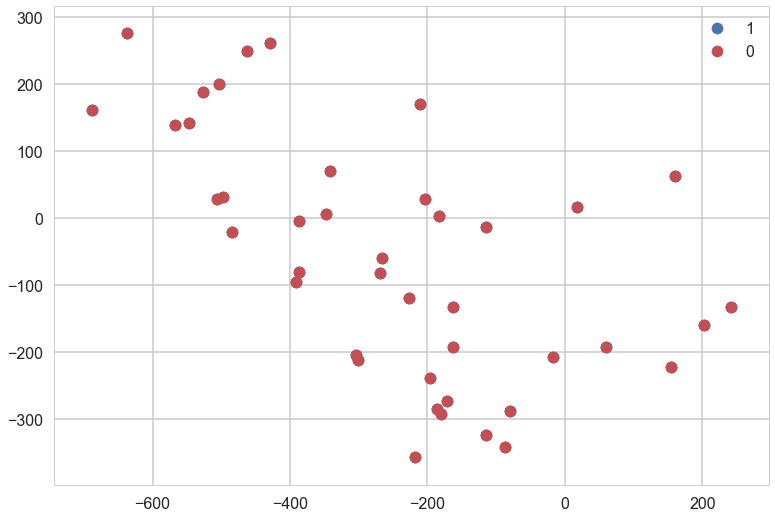

In [33]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

colors = [c0, c2]
for label, color in zip(df['WSTAT'].unique(), colors):
    mask = df['WSTAT']==0
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

### Classifying in a reduced feature space with kNN
Implicit in the notion of classification, is the idea that samples close to each other in feature-space share a label. kNN is a very simple algorithm to diretly use this idea to do classification. The basic notion is this: if a lot of samples in some area of the feature space belong to one class as compared to the other, we'll label that part of the feature space as "belonging" to that class. This process will then classify the feature space into class-based regions. Then, given the point in feature space, we find which region its in and thus its class.

The way kNN does this is to ask for the k nearest neighbors in the training set of the new sample. To answer this question, we would define a distance in the feature space (Note that this distance is different from the error or risk measures we have seen earlier). This distance is typically defined as the Euclidean distance, the sum of the square of the difference of each feature value between any two samples.

Once we have a distance measure, we can sort the distances from the current sample. Then we choose the $k$ closest ones in the training set, where $k$ is an odd number (to break ties) like 1,3,5,...19,. We now see how many of these $k$ "nearest neighbors" belong to one class or the other, and choose the majority class amongst those neighbors as our sample's class.
The training process thus simply consists of memorizing the data, perhaps using a database to aid in the fast lookup of the $k$ nearest training set neighbors of any point in feature space.

We will use sklearn's simple api to write the classifier:

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
df['y'] = df['WSTAT']
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print ("Accuracy on training data: %0.2f" % (training_accuracy))
        print ("Accuracy on test data:     %0.2f" % (test_accuracy))
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

C:\Users\Angus\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Lets see what happens when we choose $k=1$. On the training set, the 1NN classifier memorizes the training data. It will predict perfectly on the training set, and wont do too badly on the test set, especially deep in the regions of feature space where one or the other class dominates. This is because even one neighbor might be enough in those regions. However, the same classifier will do badly near the clasification boundaries on the test set, because you will need more than one neighbor to decide with any certainty of the class.
The result of this is, as you might expect, the regions of feature space classfied one way or the other are quite jagged and mottled. Since we are choosing just one neighbor, we fit to the noise in the region rather than the trend. We are overfitting.

Accuracy on training data: 1.00
Accuracy on test data:     0.62


(1, 1.0, 0.61904761904761907)

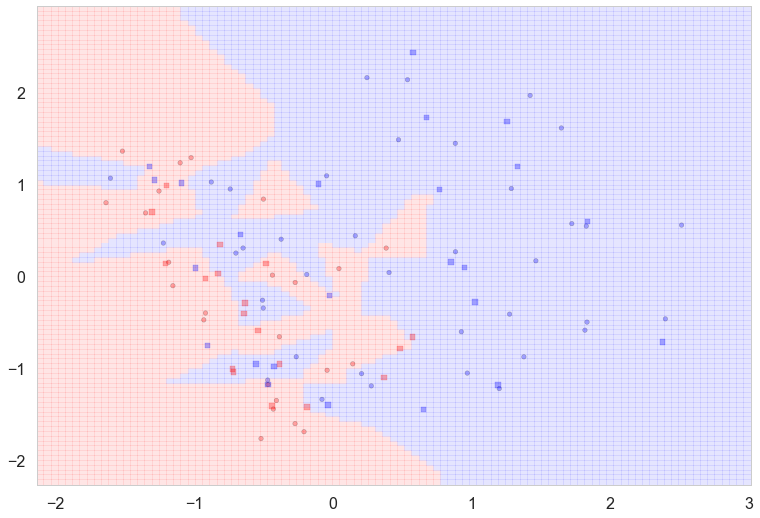

In [38]:
classify(Xs,ys,1)

If we choose a large number for $k$, such as 3, we are wandering too far from our original sample,and thus we average over a large amount of the feature space. This leads to a very biased classification, depending on where our sample is, but extending far out from there. Our classification may even cover the entire feature space, then giving us the majority class.
In terms of probabilities, such an underfit case gives us the base rate classifier. Imagine $k=N$. Then the probability is just the fraction of training set examples in a given class. Say this number for the blue class is 0.4 (that is, when we have uneven class memberships in the training set). Now, on any random test set, if we use the classifier which says "classify all as red", we will be correct, on average, 60% of the time if the test set and training sets are representative of the population of samples. Any classifier we create must do a better job than this!

Accuracy on training data: 0.76
Accuracy on test data:     0.67


(3, 0.75806451612903225, 0.66666666666666663)

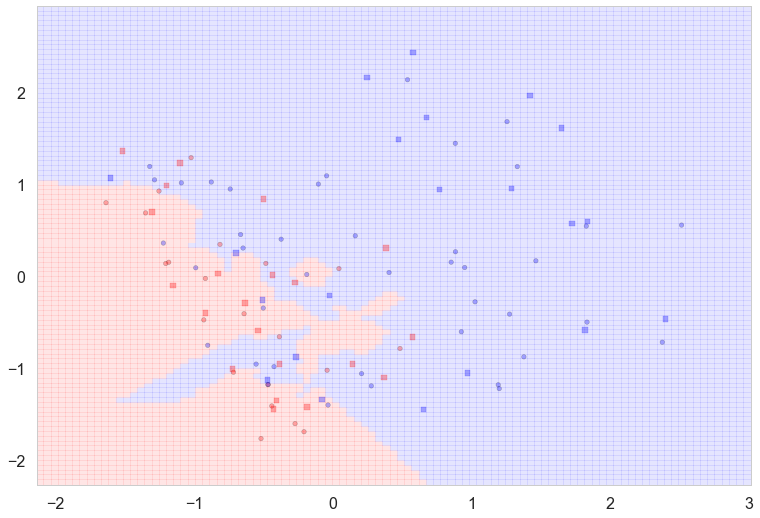

In [39]:
classify(Xs,ys,3)#run this a few times

We notice that kNN will be quite stable far away from the classification bondary, but is likely to be more jagged near the classification boundary. Having a reasonable number for $k$ will "smooth" the jaged edges out.
We thus once again need to find the balance between the high bias (large $k$) case and the high variance (low $k$) case, and once again we turn to our error vs complexity curve to find the appropriate $k$.

### Error against complexity (k), and cross-validation

In [40]:
fits={}
for k in np.arange(1,45,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

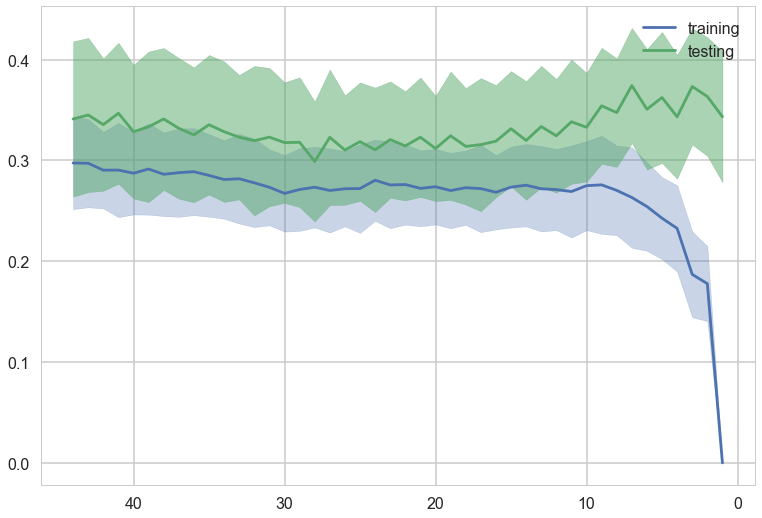

In [41]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

Once again, as before, we plot the test error and training errors against the number of neighbors $k$ . Here $k$ serves as a complexity parameter, with small $k$ being more "wiggly" in the classification of neighborhoods and large $k$ oversmoothing the classification. Notice that we plot $k$ reversed on the x-axis so as to go from lower complexity to higher complexity. As expected, the training error drops with complexity, but the test error starts going back up. 

### Setting up Code using Cross Validation
In this section, we will set some code up for classification using cross-validation so that we can easily run classification models in scikit-learn. We first set up a function cv_optimize which takes a classifier clf, a grid of hyperparameters (such as a complexity parameter or regularization parameter) implemented as a dictionary parameters, a training set (as a samples x features array) Xtrain, and a set of labels ytrain. The code takes the traning set, splits it into n_folds parts, sets up n_folds folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and returns the best classifier to us.

In [42]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

We will then use this best classifier to fit the entire training set. This is done inside the do_classify function which takes a dataframe indf as input. It takes the columns in the list featurenames as the features used to train the classifier. The column targetname sets the target. The classification is done by setting those samples for which targetname has value target1val to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired. (Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation. We then train the model on the training set using cross-validation. Having obtained the best classifier using cv_optimize, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

In [43]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

### Cross-validation
Now we are training on a smaller set and we plot the results in a diagram below. The results are fairly stable and correspond to our intuition that the first principal component basically separates the data.

In [52]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1,40,2)}, df, ['pc1','pc2'], df.y, 1)

BEST PARAMS {'n_neighbors': 11}
Accuracy on training data: 0.75
Accuracy on test data:     0.62


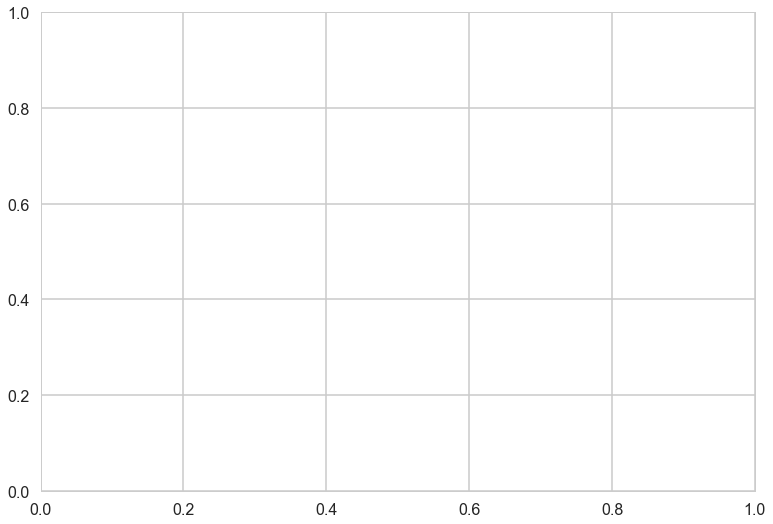

In [64]:
plt.figure()
ax=plt.gca()
#points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

#### Logistic Regression
Remember the 1-0 loss we talked about earlier? It turns out that minimizing the 1-0 loss with respect to some parameters of our model is very hard to do, for technical reasons of the 1-0 loss not being a convex loss (beyond the scope of this course). Thus it makes sense tolook for alternate approaches. One approach that we know about already is linear regression.
We could approach classification as linear regression, there the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and futhermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Thus this does not seem like a very good idea.

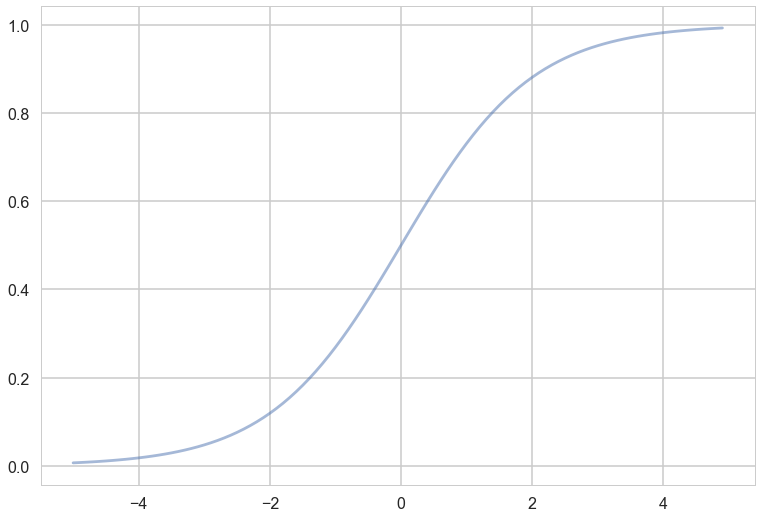

In [67]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [68]:
dflog.head()

,DAYS,DATE,COALP,OILP,GPROD,GCONS,GASP,WEATH,WSTAT,GPSTAT
0,245,2008-12-31,57.22,41.12,2227.028,2399.702,5.82,WINTER,1,HIGH
1,276,2009-01-31,54.37,41.71,2251.938,2729.715,5.24,WINTER,1,HIGH
2,304,2009-02-28,52.30,39.09,2074.167,2332.539,4.52,WINTER,1,HIGH
3,335,2009-03-31,44.34,47.94,2262.488,2170.709,3.96,WINTER,1,HIGH
4,365,2009-04-30,41.92,49.65,2147.856,1741.293,3.50,SPRING,0,HIGH


In [78]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['GCONS', 'GASP'], 'WSTAT', 1)

BEST PARAMS {'C': 100}
Accuracy on training data: 0.76
Accuracy on test data:     0.67


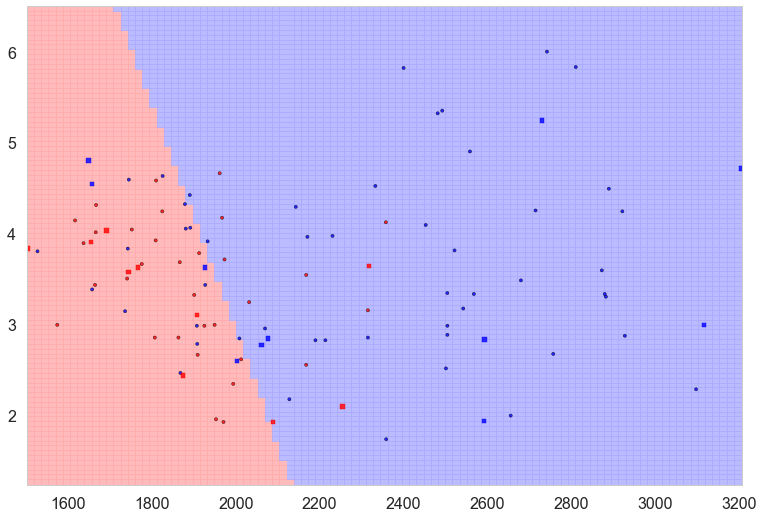

In [79]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.8);

In the figure here showing the results of the logistic regression, we plot the actual labels of both the training(circles) and test(squares) samples. The 0's (Spring & Fall) are plotted in red, the 1's (Winter & Summer) in blue. We also show the classification boundary, a line (to the resolution of a grid square). Every sample on the red background side of the line will be classified female, and every sample on the blue side, male. Notice that most of the samples are classified well, but there are misclassified people on both sides, as evidenced by leakage of dots or squares of one color onto the side of the other color. Both test and training accuracy are 67% and 76% respectively.

#### The probabilistic interpretaion
Remember we said earlier that if $h &gt; 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h(\v{w}\cdot\v{x})$ with the probability that the sample is a '1' ($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\ge 0.5$.

It's important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram). If for example the probability of classifying a test sample as a '0' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.
Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'.

### Maximizing the probability of the training set.
Now if we maximize $$P(y|\v{x},\v{w})$$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called maximum likelihood estimation since we are maximising the likelihood of the training data y.

Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood, since all we did was to minimize the negative log-likelihood over the training samples.
sklearn will return the probabilities for our samples, or for that matter, for any input vector set $\{\v{x}_i\}$, i.e. $P(y_i | \v{x}_i, \v{w})$:

In [80]:
clf_l.predict_proba(Xtest_l)

array([[ 0.66843328,  0.33156672],
       [ 0.12874469,  0.87125531],
       [ 0.7195911 ,  0.2804089 ],
       [ 0.32616939,  0.67383061],
       [ 0.50779376,  0.49220624],
       [ 0.48324484,  0.51675516],
       [ 0.01554571,  0.98445429],
       [ 0.4273947 ,  0.5726053 ],
       [ 0.00684624,  0.99315376],
       [ 0.44653237,  0.55346763],
       [ 0.67887769,  0.32112231],
       [ 0.6393594 ,  0.3606406 ],
       [ 0.68386116,  0.31613884],
       [ 0.671114  ,  0.328886  ],
       [ 0.19656268,  0.80343732],
       [ 0.51295419,  0.48704581],
       [ 0.03255724,  0.96744276],
       [ 0.10143899,  0.89856101],
       [ 0.64929453,  0.35070547],
       [ 0.56296446,  0.43703554],
       [ 0.82044613,  0.17955387]])

### Discriminative classifier
Logistic regression is what is known as a discriminative classifier. Let us plot the probabilities obtained from predict_proba, overlayed on the samples with their true labels:

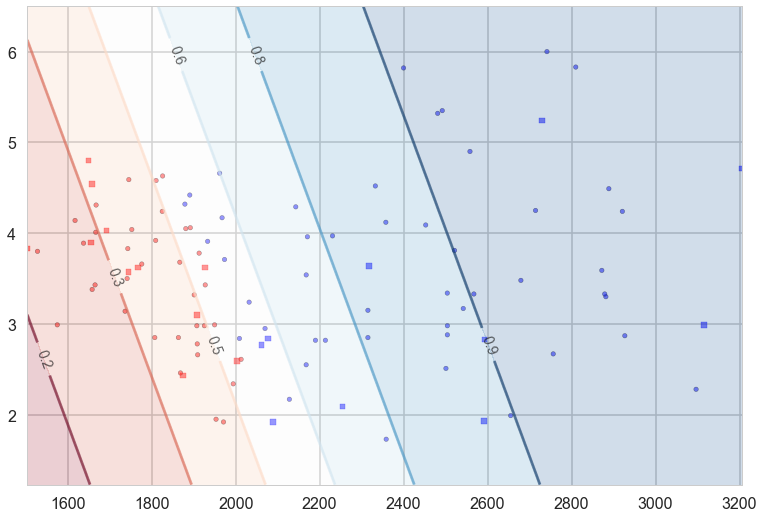

In [82]:
plt.figure()
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.5);

Notice that lines of equal probability, as might be expected are straight lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (Winter & Summer), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

This notion of trying to obtain the line or boundary of demarcation is what is called a discriminative classifier. The algorithm tries to find a decision boundary that separates the Winter & Summer Gas Prices from the Spring & Fall Gas Prices. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\v{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\v{x},\v{w})$?
